In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib as mpl

%matplotlib notebook

In [2]:
def load_and_normalize(dataset, path, train=True):
    data = dataset(path, train=train, download=True)
    np_data = data.train_data.numpy() if train else data.test_data.numpy()
    
    if len(np_data.shape) < 4:
        data_with_channels = np.expand_dims(np_data, axis=1)
    else:
        data_with_channels = np_data
    
    axis_except_channels = tuple(x for x in range(len(data_with_channels.shape)) if x != 1)
    
    mean = np.mean(data_with_channels, axis=axis_except_channels) / 255
    std = np.std(data_with_channels, axis=axis_except_channels) / 255
    
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
               ])
    
    transformed = dataset(path, train=train, download=True, transform=transform)
    return transformed

In [3]:
def fashion_mnist(batch_size=50, valid=0, shuffle=True, path="./FashionMNIST_data"):
    
    test_data = load_and_normalize(datasets.FashionMNIST, path, train=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    train_data = load_and_normalize(datasets.FashionMNIST, path, train=True)
        
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, None, test_loader

In [4]:
def train(epoch, model, print_report=True):
    train_size = len(train_loader.sampler)
    line_format = "Train Epoch: {} [{:05d}/{} ({:.0f}%)]\tLoss: {:.6f}"
    
    for batch_idx, (data, target) in enumerate(train_loader):
        model.optim.zero_grad()
        output = model(data)
        loss = model.loss(output, target)
        loss.backward()
        model.optim.step()
            
        if batch_idx % 200 == 0 and print_report:
            processed = batch_idx * len(data)
            percentage = 100. * batch_idx / len(train_loader)
            line = line_format.format(epoch, processed, train_size, percentage, model._loss.item())
            print(line)
            
    else:
        batch_idx += 1
        if print_report:
            line = line_format.format(epoch, train_size, train_size, 100, model._loss.item())
            print(line)
    return model._loss.item()

In [5]:
def test(model, loader, print_report=True):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: "Loss: {:.4f}".format(l)
    acc_lambda = lambda c, p: "Accuracy: {}/{} ({:.0f}%)".format(c, test_size, p)
    line = lambda l, c, p: avg_lambda(l) + "\t" + acc_lambda(c, p)

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            test_loss += model.loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    test_loss /= test_size
    correct_pct = 100. * correct / test_size
    if print_report:
        report = "Test set:\n" + line(test_loss, correct, correct_pct) + "\n"
        print(report)
    return test_loss, correct_pct.item()

In [6]:
def plot_results(epochs, train_losses, test_losses, correct_percentages):
    x = list(range(1, epochs+1))
    mpl.pyplot.figure(figsize=(20,10))
    mpl.pyplot.grid()
    mpl.pyplot.plot(x, np.log1p(train_losses), "ro", label="Train")
    mpl.pyplot.plot(x, np.log1p(test_losses), "gP", label="Test")
    mpl.pyplot.xlabel("Epoch")
    mpl.pyplot.ylabel("log(loss)")
    mpl.pyplot.legend()
    mpl.pyplot.show()
    
    mpl.pyplot.figure(figsize=(20,10))
    mpl.pyplot.grid()
    mpl.pyplot.plot(x, correct_percentages, "bo")
    mpl.pyplot.xlabel("Epoch")
    mpl.pyplot.ylabel("%")
    mpl.pyplot.show()

In [7]:
class OverfittingNet(nn.Module):
    def __init__(self, lr=0.01):
        super(OverfittingNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128*2)
        self.fc3 = nn.Linear(128*2, 128*3)
        self.fc4 = nn.Linear(128*3, 10)        
        self.bn = nn.BatchNorm1d(128)
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=0.)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.bn(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [8]:
train_loader, validation_loader, test_loader = fashion_mnist(valid=10000)

In [9]:
model = OverfittingNet()

In [10]:
epochs = 500

In [11]:
train_losses, test_losses, correct_percentages = [], [], []
message_format = "Epoch {}: train loss - {}, test loss - {}, correct_percentage - {}"
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = train(epoch, model, print_report=False)
    model.eval()
    test_loss, correct_pct = test(model, validation_loader, print_report=False)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    correct_percentages.append(correct_pct)
    if epoch % 10 == 0:
        print(message_format.format(epoch, train_losses[-1], test_losses[-1], correct_percentages[-1]))

Epoch 10: train loss - 0.45995739102363586, test loss - 0.36888539226055145, correct_percentage - 87
Epoch 20: train loss - 0.24821235239505768, test loss - 1.3865774426698685, correct_percentage - 87
Epoch 30: train loss - 0.2977604568004608, test loss - 4.667740410852432, correct_percentage - 88
Epoch 40: train loss - 0.20567430555820465, test loss - 10.05784326968193, correct_percentage - 88
Epoch 50: train loss - 0.233014777302742, test loss - 92.87219250731468, correct_percentage - 87
Epoch 60: train loss - 0.35854145884513855, test loss - 10.850252226305008, correct_percentage - 88
Epoch 70: train loss - 0.16195444762706757, test loss - 64.01801690034867, correct_percentage - 87
Epoch 80: train loss - 0.31823456287384033, test loss - 24.582248151397707, correct_percentage - 87
Epoch 90: train loss - 0.3547113835811615, test loss - 21.596923538208006, correct_percentage - 88
Epoch 100: train loss - 0.1885850578546524, test loss - 69.55516102306842, correct_percentage - 87
Epoch 11

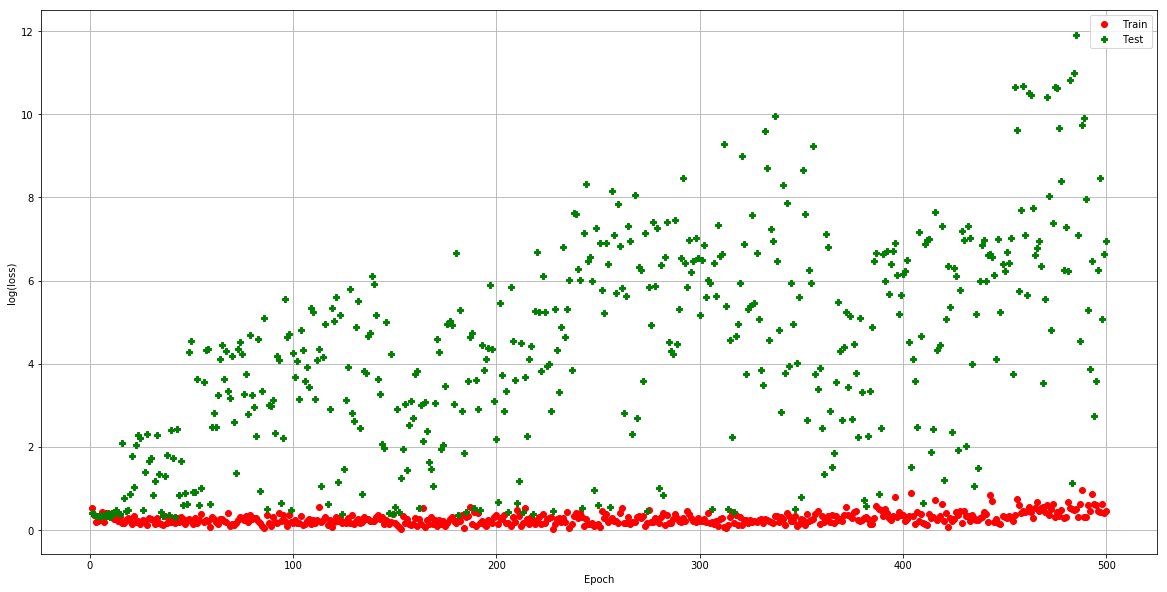

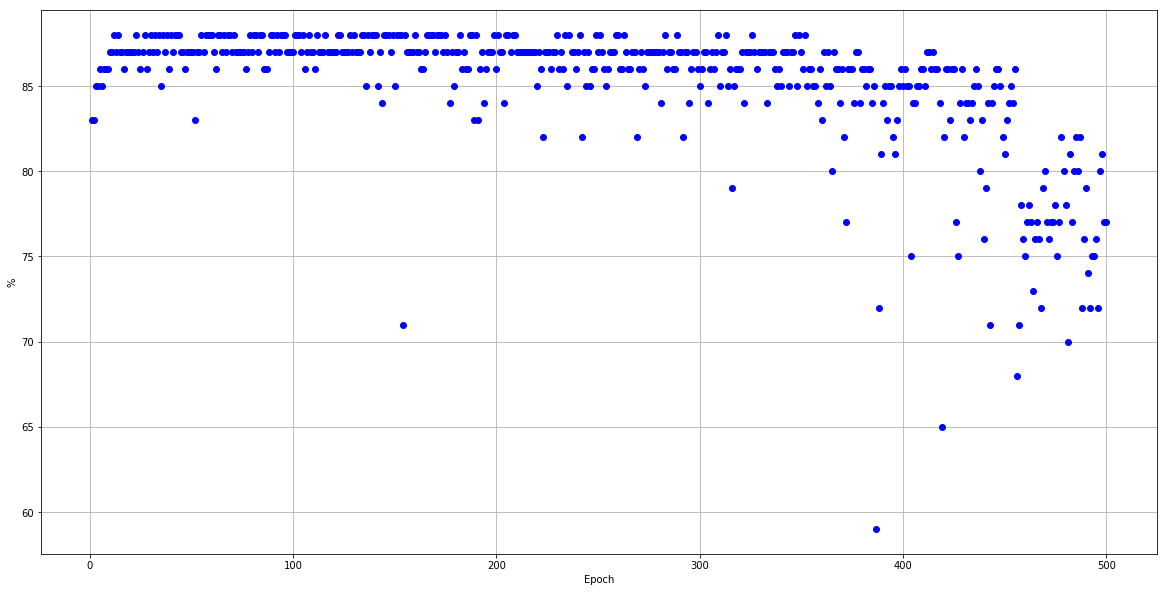

In [12]:
plot_results(epochs, train_losses, test_losses, correct_percentages)